In [1]:
import sys
import os
import importlib
import glob
import random
from itertools import combinations

import numpy as np
import scipy
import sklearn
import shap

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

import mdtraj as md

import extq

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
cm_seq2 = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.8, dark=0.1, as_cmap=True, reverse=False
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

# Load Data

In [4]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))

In [5]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [6]:
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

In [7]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(4150115, 2) (4150115, 60)


In [8]:
# load committors
q = np.load("../../data/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns
w = np.load(
    "../../data/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True
)[0]

# Linear regression against salt bridge distances and S4 helix CVs

In [9]:
X = np.hstack((cv_arr, sb_arr))
y = np.concatenate(q)
print(X.shape, y.shape)

(4150115, 62) (4150115,)


In [10]:
# linear regression
lr_model = sklearn.linear_model.LinearRegression(n_jobs=-1)
lr_model.fit(X, y)

LinearRegression(n_jobs=-1)

In [11]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(i, "=", lr_model.coef_[i].round(4))

Model coefficients:

0 = -0.0025
1 = -0.0005
2 = -0.2989
3 = 0.1869
4 = -0.0672
5 = 0.0727
6 = 0.0695
7 = -0.0254
8 = 0.438
9 = -0.3398
10 = 0.2809
11 = -0.4874
12 = 1.4051
13 = -1.0653
14 = -0.2325
15 = 0.3283
16 = -0.5043
17 = 0.5312
18 = -2.4845
19 = 2.0148
20 = -0.2362
21 = -0.2468
22 = 0.9132
23 = -0.712
24 = 1.9183
25 = -1.5396
26 = 0.1457
27 = 0.2117
28 = -0.7195
29 = 0.5334
30 = -0.7909
31 = 0.4737
32 = -0.031
33 = -0.02
34 = 0.0324
35 = 0.0189
36 = -0.1637
37 = 0.144
38 = 0.178
39 = 0.0077
40 = 0.0352
41 = -0.0876
42 = 0.2732
43 = -0.1104
44 = -0.1149
45 = 0.0415
46 = -0.1431
47 = 0.2708
48 = -0.1813
49 = 0.1335
50 = -0.0589
51 = 0.0581
52 = -0.036
53 = -0.1437
54 = 0.0382
55 = 0.0666
56 = 0.0587
57 = -0.1296
58 = 0.1224
59 = -0.0252
60 = -0.0671
61 = -0.0842


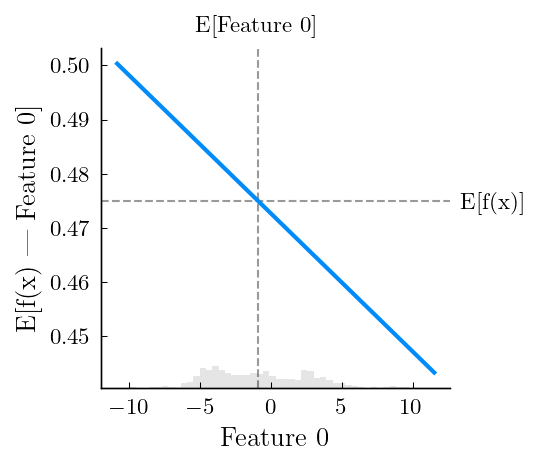

In [12]:
X1000 = shap.utils.sample(X, 1000)
shap.plots.partial_dependence(
    0,
    lr_model.predict,
    X1000,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

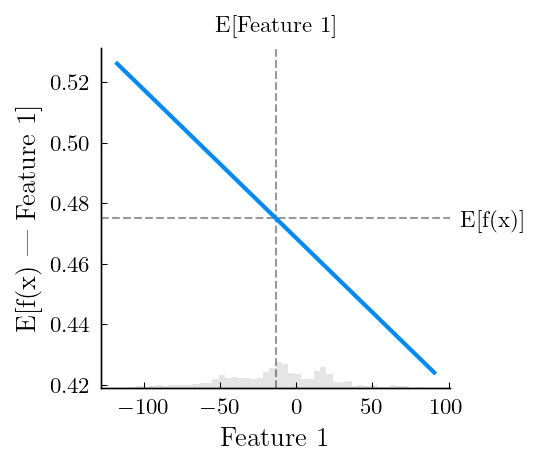

In [13]:
X1000 = shap.utils.sample(X, 1000)
shap.plots.partial_dependence(
    1,
    lr_model.predict,
    X1000,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

In [15]:
explainer = shap.Explainer(lr_model.predict, X1000)
shap_values = explainer(X[::100])

Permutation explainer: 41503it [09:21, 72.65it/s]                           


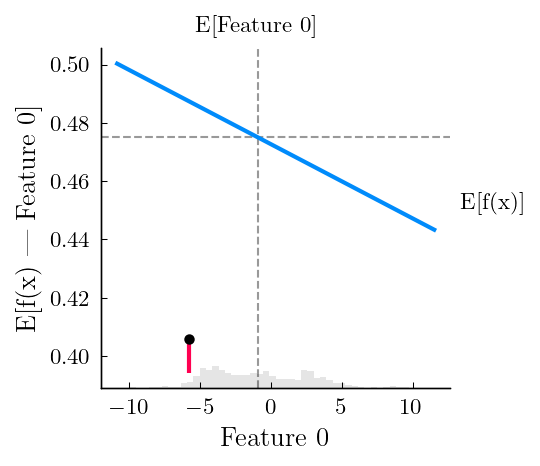

In [17]:
# make a standard partial dependence plot
sample_ind = 0
shap.partial_dependence_plot(
    sample_ind,
    lr_model.predict,
    X1000,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)

In [19]:
shap_values.shape

(41502, 62)

In [25]:
type(shap_values)

shap._explanation.Explanation

In [22]:
shap.plots.scatter(shap_values[:, :2])

TypeError: object of type 'NoneType' has no len()

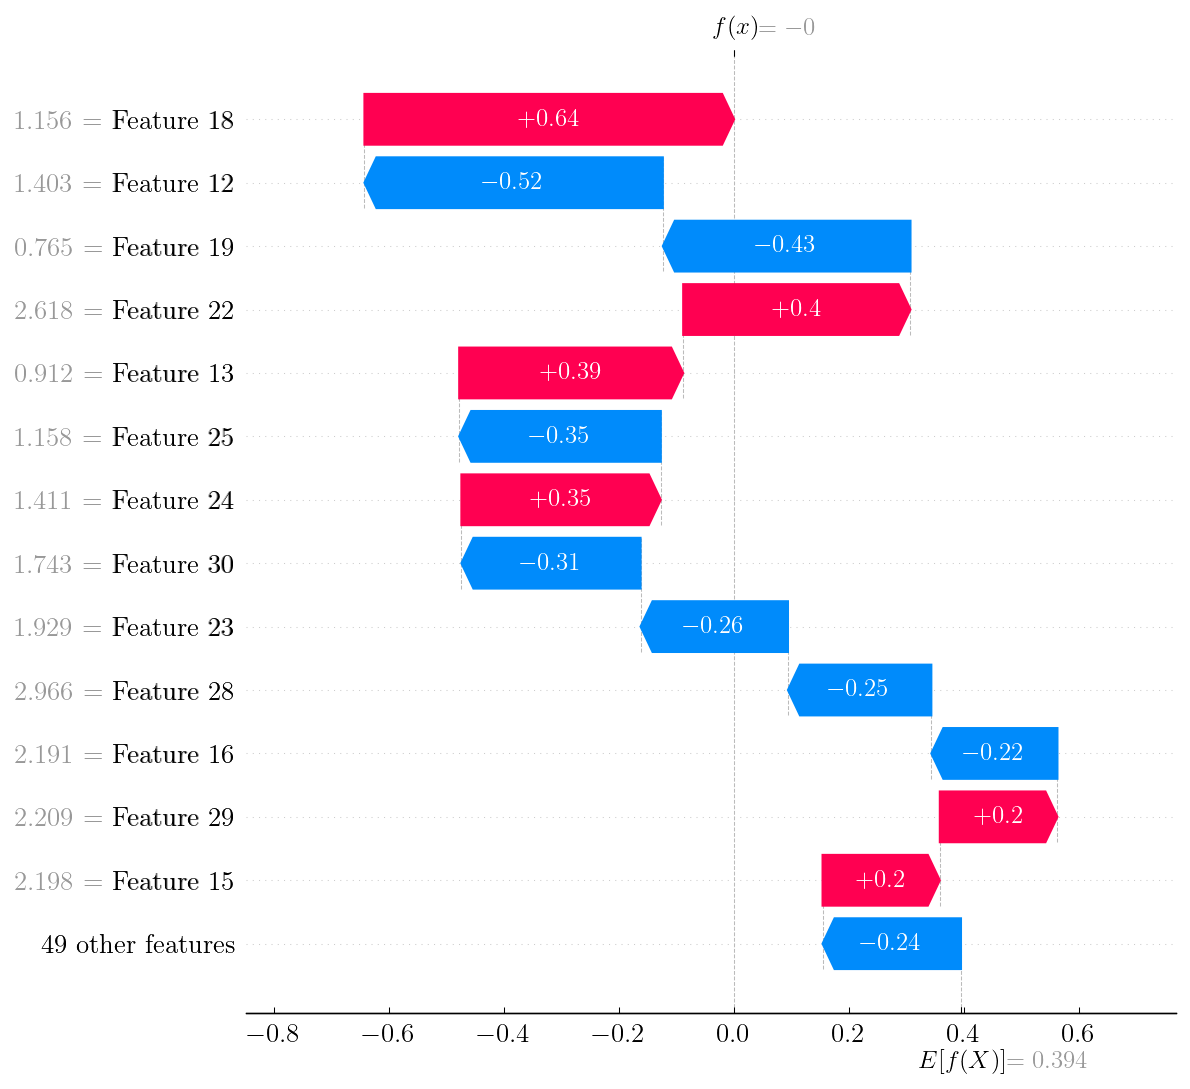

In [27]:
shap.plots.waterfall(shap_values[0], max_display=14)

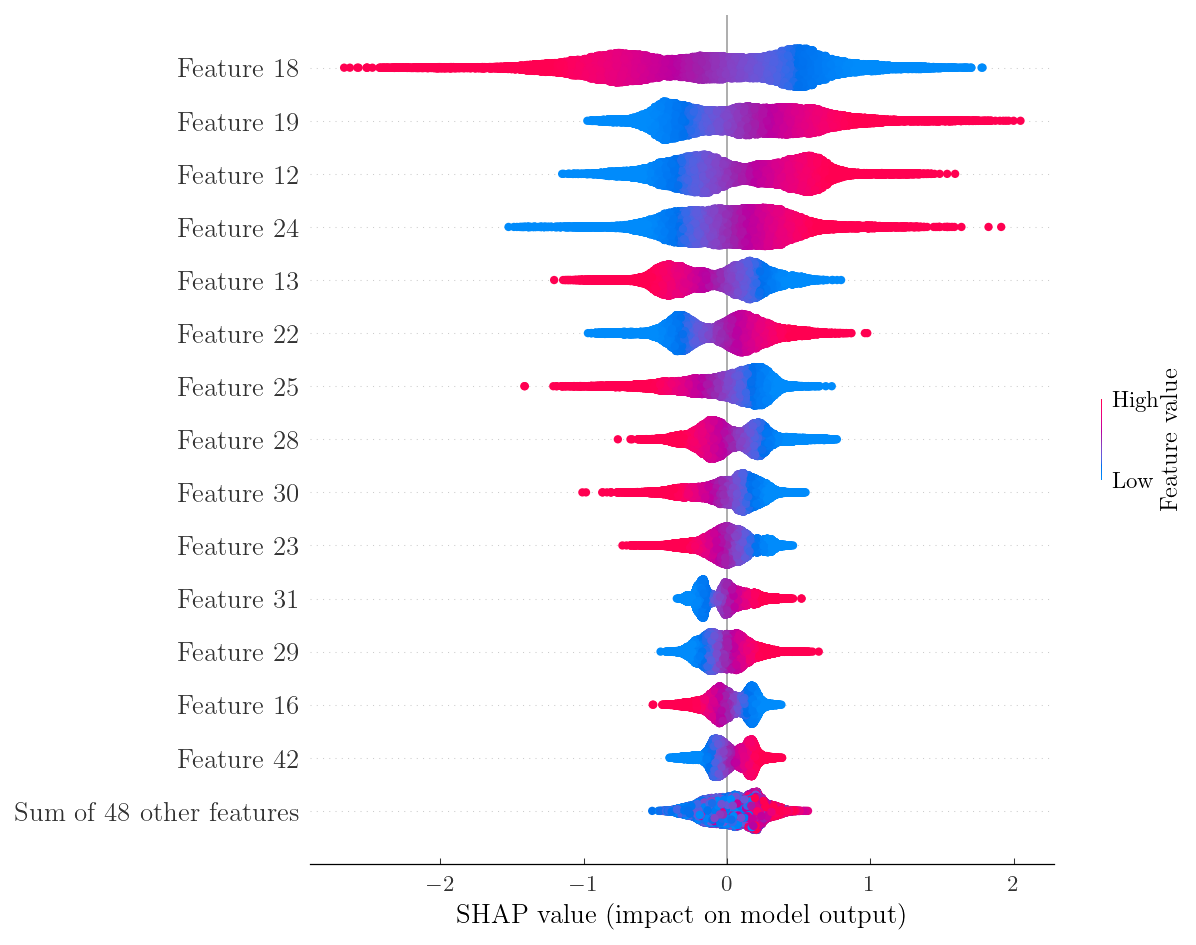

In [29]:
shap.plots.beeswarm(shap_values, max_display=15)

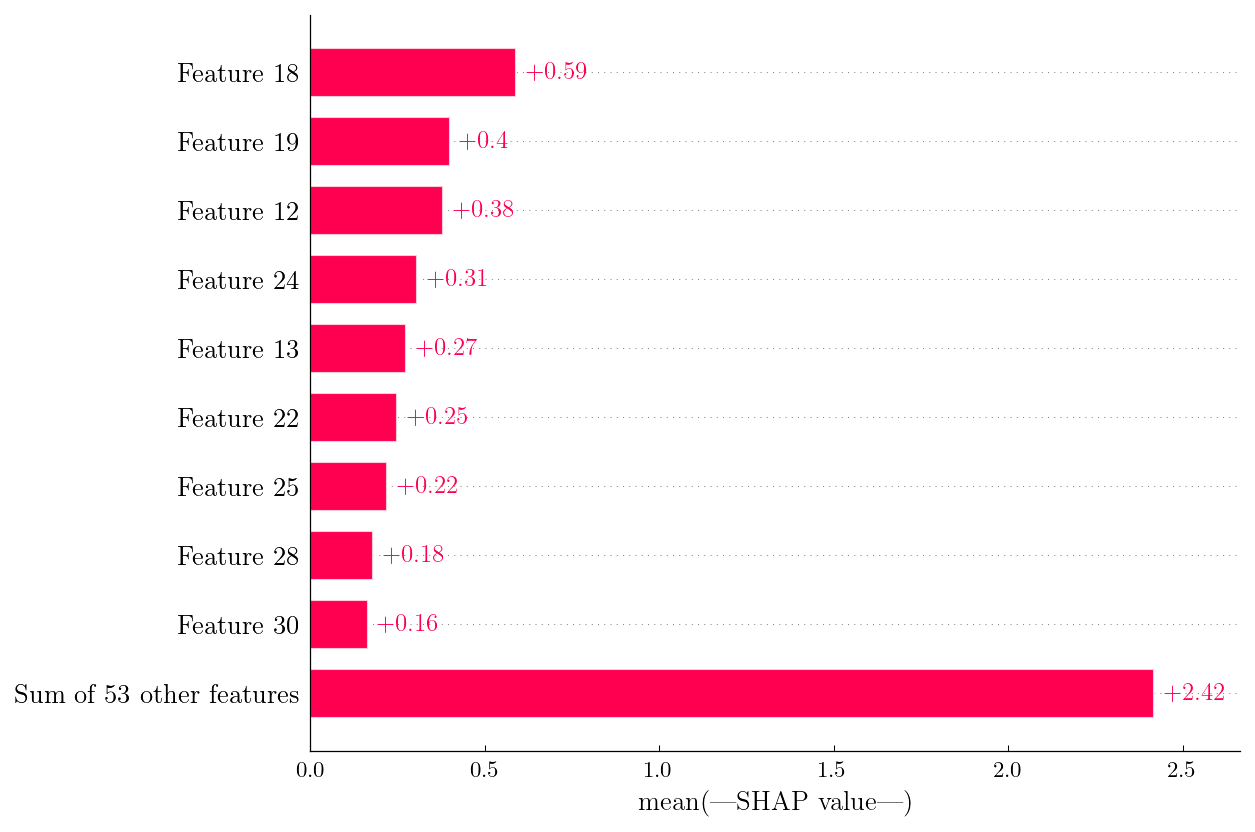

In [35]:
shap.plots.bar(shap_values)

In [43]:
shap.plots.scatter(shap_values)

TypeError: object of type 'NoneType' has no len()

In [32]:
sb_labels[22]

'R229 - E183'

# Logistic regression

In [33]:
logist_model = sklearn.linear_model.LogisticRegression(n_jobs=-1)
logist_model.fit(X, y)

ValueError: Unknown label type: 'continuous'

In [34]:
# regress on logit log (p / 1-p)
logit_y = np.log(y / (1 - y))

divide by zero encountered in true_divide
divide by zero encountered in log
invalid value encountered in log
